<p>В этом конкурсе вы будете работать со сложным набором данных тайм-ряда, состоящим из ежедневных данных о продажах, любезно предоставленных одной из крупнейших российских фирм-разработчиков программного обеспечения - компанией 1С. </p>

<p>Мы просим вас предсказать общий объем продаж для каждого продукта и магазина в следующем месяце. Решая эту конкуренцию, вы сможете применить и улучшить свои навыки науки о данных.</p>

In [144]:
from pandas import read_csv
import pandas as pd
import numpy as np
from math import pi
from scipy.optimize import minimize
from sklearn import preprocessing

from sklearn.model_selection import KFold # задаем части, на которые разобьем выборку
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

In [78]:
filename = 'data\item_categories.csv'
item_categories = read_csv(filename)
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [79]:
filename = 'data\items.csv'
items = read_csv(filename)
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [80]:
filename = 'data\sales_train.csv'
sales_train = read_csv(filename)
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


<p>date_block_num - последовательный месячный номер, используемый для удобства. Январь 2013 является 0, Февраль 2013 является 1,..., октября 2015 составляет 33</p>
<p>item_cnt_day - количество проданных продуктов. Вы прогнозируете ежемесячную сумму этой меры</p>

In [81]:
filename = 'data\shops.csv'
shops = read_csv(filename)
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Зададим столбец, который будет соответствовать таблице продаж и содержать значения соответствующих id категорий

In [8]:
lst = []
for i in sales_train['item_id'].values:
    num_category = items[items['item_id'] == i]['item_category_id'].values
    lst.append(num_category)
    
y = pd.DataFrame(lst)
y.head()

,0
0,37
1,58
2,58
3,58
4,56


Создаем в таблице магазинов столбец с наименованиями городов

In [9]:
lst = []
for i in shops['shop_name'].values:
    name_town = i.split()
    lst.append(name_town[0])

In [10]:
shops['towns'] = lst
shops.head()

,shop_name,shop_id,towns
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


В соответствие каждому городу поставим числовое значение

In [11]:
uniq_town = shops['towns'].unique()
uniq_town

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [12]:
le = preprocessing.LabelEncoder()
le.fit(uniq_town)

LabelEncoder()

In [13]:
id_town = le.transform(shops['towns'])
shops['id_town'] = id_town
shops.head()

,shop_name,shop_id,towns,id_town
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,0
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,0
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3


In [14]:
lst = []
for i in sales_train['shop_id'].values:
    num_town = shops[shops['shop_id'] == i]['id_town'].values
    lst.append(num_town)
    
town = pd.DataFrame(lst)
town.head()

,0
0,31
1,14
2,14
3,14
4,14


Вытащим из каждой даты номер месяца

In [15]:
lst = []
for i in sales_train['date'].values:
    num_month = int(i.split('.')[1])
    lst.append(num_month)
    
m = pd.DataFrame(lst)
m.head()

,0
0,1
1,1
2,1
3,1
4,1


Вытащим из каждой даты номер дня, чтобы сопоставить ему день недели

In [16]:
lst = []
for i in sales_train['date'].values:
    num_month = int(i.split('.')[0])
    lst.append(num_month)
    
sales_train['day'] = lst
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day
0,02.01.2013,0,59,22154,999.00,1.0,2
1,03.01.2013,0,25,2552,899.00,1.0,3
2,05.01.2013,0,25,2552,899.00,-1.0,5
3,06.01.2013,0,25,2554,1709.05,1.0,6
4,15.01.2013,0,25,2555,1099.00,1.0,15


<p>Дни недели: пн=0, вт=1, ср=2, ..., вс=6.</p><p> 02-01-2013 - это среда.<p>

In [17]:
first_el = 2
num_day_of_week = [first_el]

for i in range(1, len(sales_train['day'])):
    num = (num_day_of_week[-1] + (sales_train['day'][i] - sales_train['day'][i-1]))%7
    num_day_of_week.append(num)
    
sales_train['day_of_week'] = num_day_of_week
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,day_of_week
0,02.01.2013,0,59,22154,999.00,1.0,2,2
1,03.01.2013,0,25,2552,899.00,1.0,3,3
2,05.01.2013,0,25,2552,899.00,-1.0,5,5
3,06.01.2013,0,25,2554,1709.05,1.0,6,6
4,15.01.2013,0,25,2555,1099.00,1.0,15,1


Собираем все столбцы в одну таблицу

In [18]:
item_id = sales_train['item_id'].values
item_price = sales_train['item_price'].values 

months = m.values
day_of_week = sales_train['day_of_week'].values

category = y.values
num_of_town = town.values


item_cnt_day = sales_train['item_cnt_day'].values

In [19]:
data = {'item_id': item_id,
        'item_price': item_price,
        'months': months.flatten(),
        'day_of_week': day_of_week,
        'category_id': category.flatten(),
        'town_id': num_of_town.flatten(),
        'item_cnt_day': item_cnt_day}
df = pd.DataFrame(data)
df.head()

,item_id,item_price,months,day_of_week,category_id,town_id,item_cnt_day
0,22154,999.00,1,2,37,31,1.0
1,2552,899.00,1,3,58,14,1.0
2,2552,899.00,1,5,58,14,-1.0
3,2554,1709.05,1,6,58,14,1.0
4,2555,1099.00,1,1,56,14,1.0


## Применим к полученным данным линейную регрессию

In [20]:
df.dtypes

item_id           int64
item_price      float64
months            int64
day_of_week       int64
category_id       int64
town_id           int64
item_cnt_day    float64
dtype: object

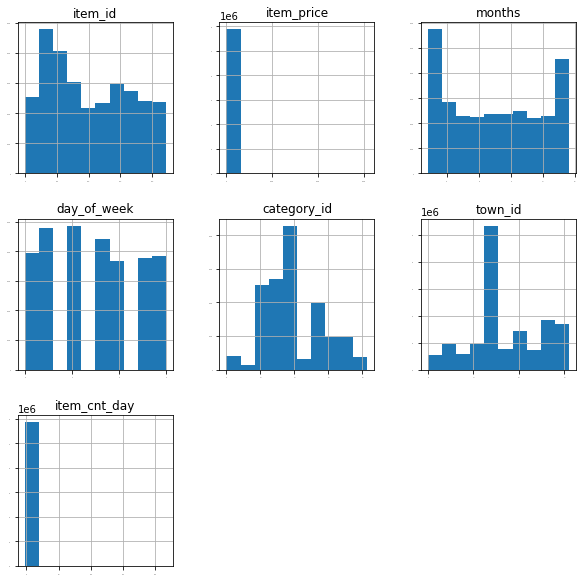

In [122]:
# гистограмма
df.hist(xlabelsize=1, ylabelsize=1, sharex=False, figsize=(10,10))
plt.show()

<AxesSubplot:>

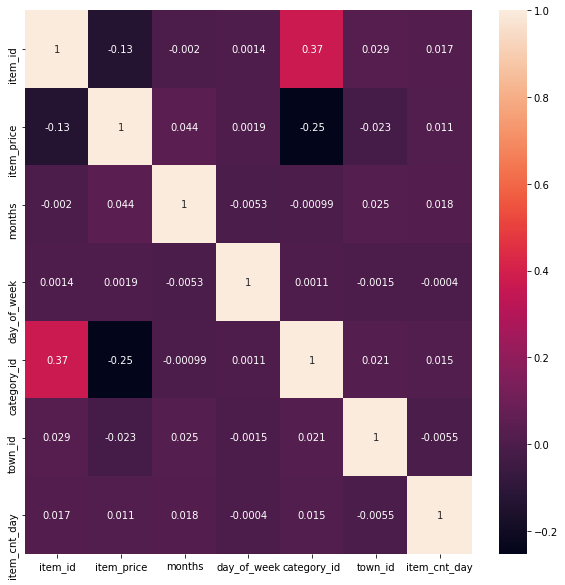

In [130]:
# коррелограмма
fig = pyplot.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

In [21]:
df.head(10)

,item_id,item_price,months,day_of_week,category_id,town_id,item_cnt_day
0,22154,999.00,1,2,37,31,1.0
1,2552,899.00,1,3,58,14,1.0
2,2552,899.00,1,5,58,14,-1.0
3,2554,1709.05,1,6,58,14,1.0
4,2555,1099.00,1,1,56,14,1.0
5,2564,349.00,1,3,59,14,1.0
6,2565,549.00,1,2,56,14,1.0
7,2572,239.00,1,4,55,14,1.0
8,2572,299.00,1,4,55,14,1.0
9,2573,299.00,1,3,55,14,3.0


In [38]:
array = df.values
X = array[:,0:6]
Y = array[:,6]

In [23]:
kFold = KFold(n_splits = 10)
model = LinearRegression() #экземпляр класса

In [24]:
# метод, которым будет оценен результат (среднеквадратичная ошибка)
scoring = 'neg_mean_squared_error'

# применим кросс-валидацию
results = cross_val_score(model, X, Y, cv = kFold, scoring = scoring)
print('Среднеквадратичная ошибка: ',results.mean())

Среднеквадратичная ошибка:  -6.852981824023692


In [39]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(X, Y)

#R^2
r_sq = model_lin_reg.score(X, Y)
print('R^2 =', r_sq)

R^2 = 0.000957832738332498


In [40]:
y_pred = model_lin_reg.predict(X)

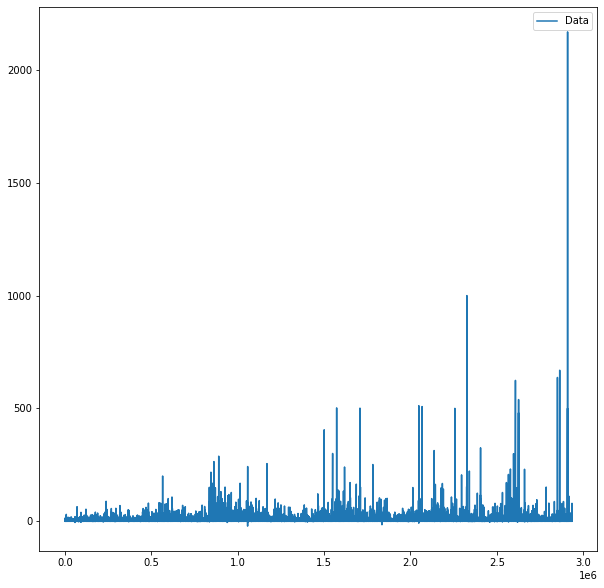

In [77]:
plt.figure(figsize=(10,10))

plt.plot(df['item_cnt_day'].values, label='Data')
#plt.plot(y_pred, label='LinReg')
plt.legend()
plt.show()

In [86]:
df['item_cnt_day'].mean()

1.242640885140891

In [42]:
#метрика качества: средняя абсолютная процентная ошибка
def MAPE(Y, y_pred):
    n = len(Y)
    slagaemoe = []
    for i in range(len(Y)):
        el = abs((Y[i] - y_pred[i])/Y[i])
        slagaemoe.append(el)

    return 1/n * sum(slagaemoe)

## Линейная, пуассоновская и гамма-регрессии

In [43]:
poisson_regression = sm.GLM(Y, 
                            X, 
                            family=sm.families.Poisson())

In [44]:
linear_regression = sm.GLM(Y, 
                           X, 
                           family=sm.families.Gaussian())

In [45]:
gamma_regression = sm.GLM(Y, 
                          X,
                          family=sm.families.Gamma())

c:\program files\python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:293: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [46]:
lin_model_results = linear_regression.fit()
poi_model_results = poisson_regression.fit()
gamma_model_results = gamma_regression.fit()

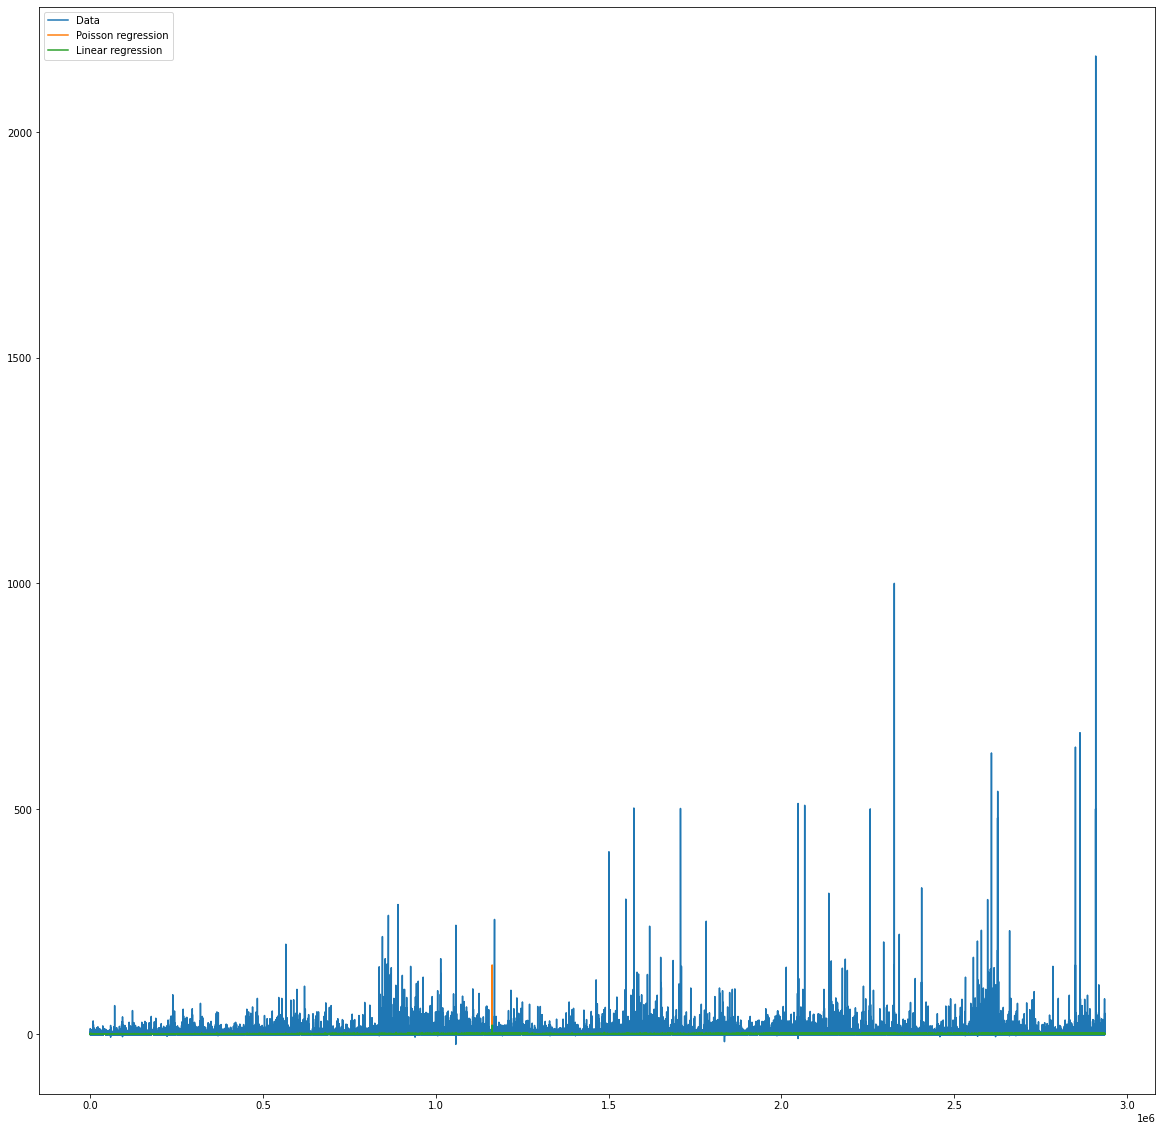

In [47]:
plt.figure(figsize=(20,20))
plt.plot(df['item_cnt_day'].values, label='Data')
plt.plot(poi_model_results.fittedvalues, label='Poisson regression')
plt.plot(lin_model_results.fittedvalues, label='Linear regression')
#plt.plot(gamma_model_results.fittedvalues, label='Gamma regression')
plt.legend()
plt.show()

In [48]:
#метрика качества: средняя абсолютная процентная ошибка
print('средняя абсолютная процентная ошибка для модели линейной регрессии =', MAPE(Y, lin_model_results.fittedvalues))
print('средняя абсолютная процентная ошибка для модели пуассоновской регрессии =', MAPE(Y, poi_model_results.fittedvalues))
print('средняя абсолютная процентная ошибка для модели гамма регрессии =', MAPE(Y, gamma_model_results.fittedvalues))

средняя абсолютная процентная ошибка для модели линейной регрессии = 0.2986892365727229
средняя абсолютная процентная ошибка для модели пуассоновской регрессии = 0.2680998931468408
средняя абсолютная процентная ошибка для модели гамма регрессии = 1.2492591619779025


# Другие регрессионные модели

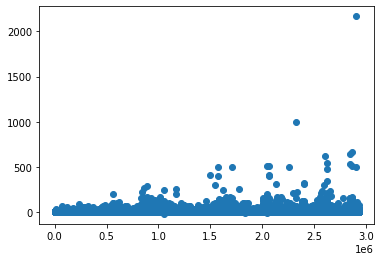

In [50]:
plt.scatter(range(len(Y)), Y)

In [51]:
df[df['item_cnt_day']>250]

,item_id,item_price,months,day_of_week,category_id,town_id,item_cnt_day
862929,3732,2545.135417,9,3,19,14,264.0
890790,3732,2550.597222,9,3,19,14,288.0
1170072,20949,5.000000,12,0,71,10,255.0
1501160,20949,5.000000,3,1,71,14,405.0
1549966,20949,5.000000,4,2,71,27,300.0
1573252,8057,1200.000000,4,2,32,14,401.0
1573253,8057,1200.000000,4,1,32,14,502.0
1708207,20949,5.000000,6,0,71,14,501.0
1782715,20949,5.000000,6,5,71,23,251.0
2048518,9242,1500.000000,10,2,8,8,512.0


In [116]:
df_without_stuffing = df[df['item_cnt_day']<150]
array_without_stuffing = df_without_stuffing.values
X_without_stuffing = array_without_stuffing[:,0:6]
Y_without_stuffing = array_without_stuffing[:,6]

from sklearn.model_selection import train_test_split

X_new_train, X_new_test, Y_new_train, Y_new_test = train_test_split(X_without_stuffing, Y_without_stuffing, test_size=0.3)

In [117]:
poisson_regression_without_stuffing = sm.GLM(Y_without_stuffing,
                                             X_without_stuffing,
                                             family=sm.families.Poisson())

In [118]:
linear_regression_without_stuffing = sm.GLM(Y_without_stuffing,
                                             X_without_stuffing,
                                             family=sm.families.Gaussian())

In [119]:
gamma_regression_without_stuffing = sm.GLM(Y_without_stuffing,
                                             X_without_stuffing,
                                             family=sm.families.Gamma())

c:\program files\python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:293: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [120]:
lin_model_results_without_stuffing = linear_regression_without_stuffing.fit()
poi_model_results_without_stuffing = poisson_regression_without_stuffing.fit()
gamma_model_results_without_stuffing = gamma_regression_without_stuffing.fit()

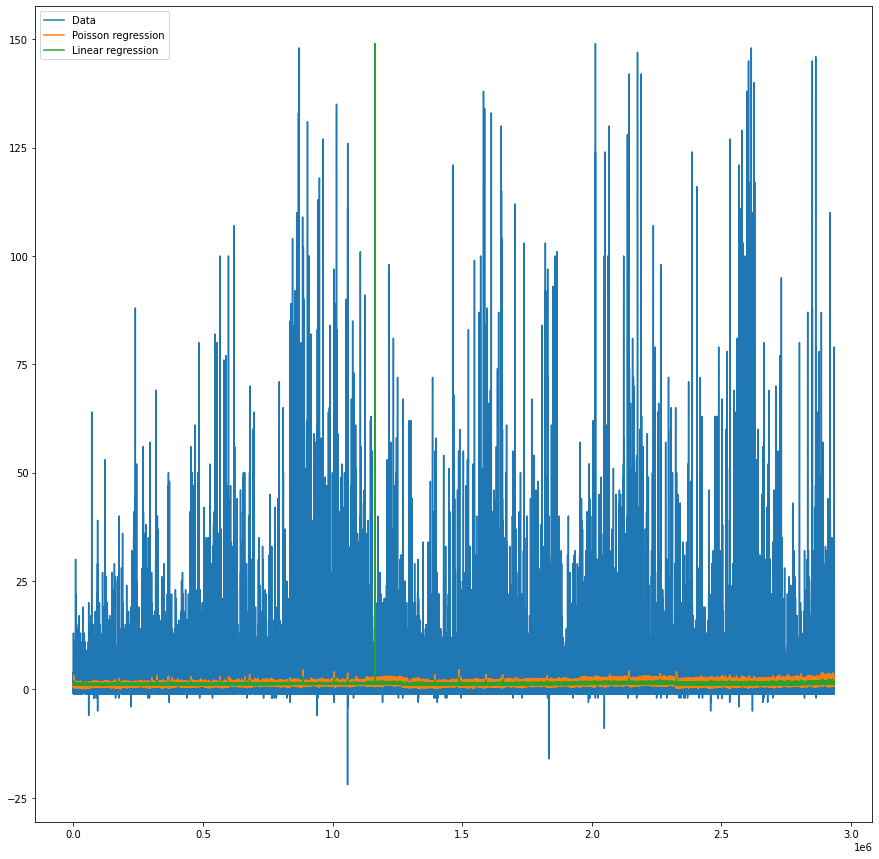

In [124]:
plt.figure(figsize=(15,15))
plt.plot(df_without_stuffing['item_cnt_day'].values, label='Data')
plt.plot(lin_model_results_without_stuffing.fittedvalues, label='Poisson regression')
plt.plot(poi_model_results_without_stuffing.fittedvalues, label='Linear regression')
#plt.plot(gamma_model_results_without_stuffing.fittedvalues, label='Gamma regression')
plt.legend()
plt.show()

In [58]:
#метрика качества: средняя абсолютная процентная ошибка
print('средняя абсолютная процентная ошибка для модели линейной регрессии =', MAPE(Y, lin_model_results.fittedvalues))
print('средняя абсолютная процентная ошибка для модели пуассоновской регрессии =', MAPE(Y, poi_model_results.fittedvalues))
print('средняя абсолютная процентная ошибка для модели гамма регрессии =', MAPE(Y, gamma_model_results.fittedvalues))

средняя абсолютная процентная ошибка для модели линейной регрессии = 0.2986892365727229
средняя абсолютная процентная ошибка для модели пуассоновской регрессии = 0.2680998931468408
средняя абсолютная процентная ошибка для модели гамма регрессии = 1.2492591619779025


In [123]:
#метрика качества: средняя абсолютная процентная ошибка
print('средняя абсолютная процентная ошибка для модели линейной регрессии =', MAPE(Y_without_stuffing, lin_model_results_without_stuffing.fittedvalues))
print('средняя абсолютная процентная ошибка для модели пуассоновской регрессии =', MAPE(Y_without_stuffing, poi_model_results_without_stuffing.fittedvalues))
print('средняя абсолютная процентная ошибка для модели гамма регрессии =', MAPE(Y_without_stuffing, gamma_model_results_without_stuffing.fittedvalues))

средняя абсолютная процентная ошибка для модели линейной регрессии = 0.2950014940326607
средняя абсолютная процентная ошибка для модели пуассоновской регрессии = 0.2627569611624647
средняя абсолютная процентная ошибка для модели гамма регрессии = 0.3775099323593572


In [60]:
model_lin_reg_without_stuffing = LinearRegression()
model_lin_reg_without_stuffing.fit(X_without_stuffing, Y_without_stuffing)

#R^2
r_sq = model_lin_reg_without_stuffing.score(X_without_stuffing, Y_without_stuffing)
print('R^2 =', r_sq)

R^2 = 0.000957832738332498


In [61]:
y_pred_without_stuffing = model_lin_reg_without_stuffing.predict(X_without_stuffing)

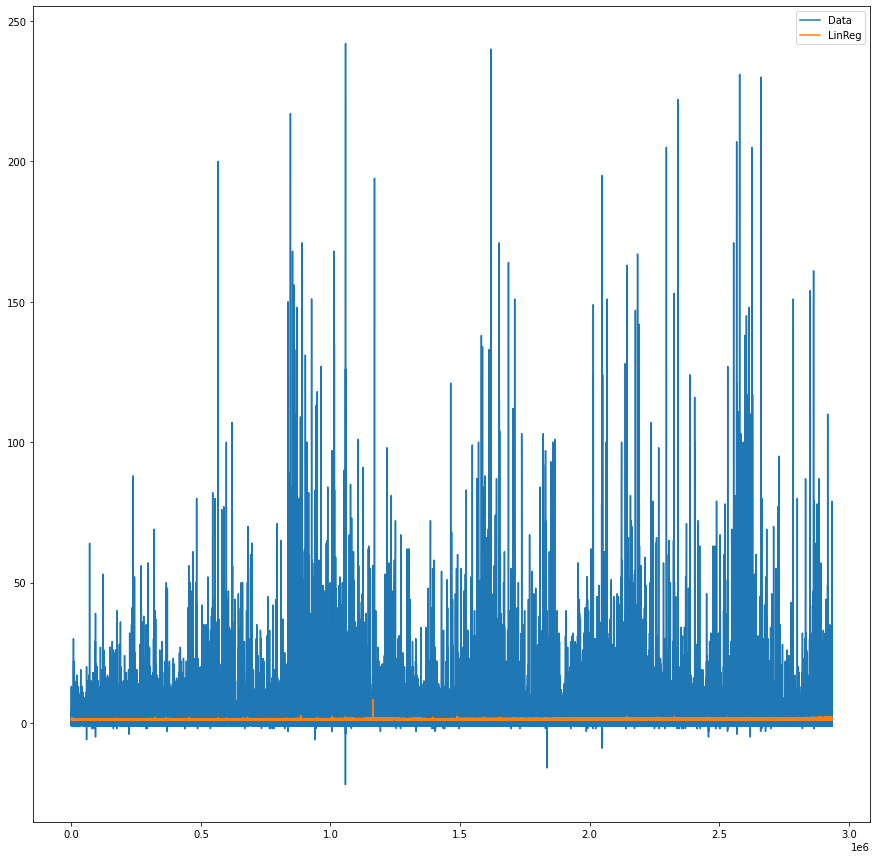

In [62]:
plt.figure(figsize=(15,15))
plt.plot(df_without_stuffing['item_cnt_day'].values, label='Data')
plt.plot(y_pred_without_stuffing, label='LinReg')
plt.legend()
plt.show()

In [63]:
from sklearn.naive_bayes import GaussianNB

modelNB = GaussianNB()
modelNB.fit(X_without_stuffing, Y_without_stuffing)

#R^2
r_sq = modelNB.score(X_without_stuffing, Y_without_stuffing)
print('R^2 =', r_sq)

R^2 = 0.8858776456146076


In [64]:
y_NB = modelNB.predict(X_without_stuffing)

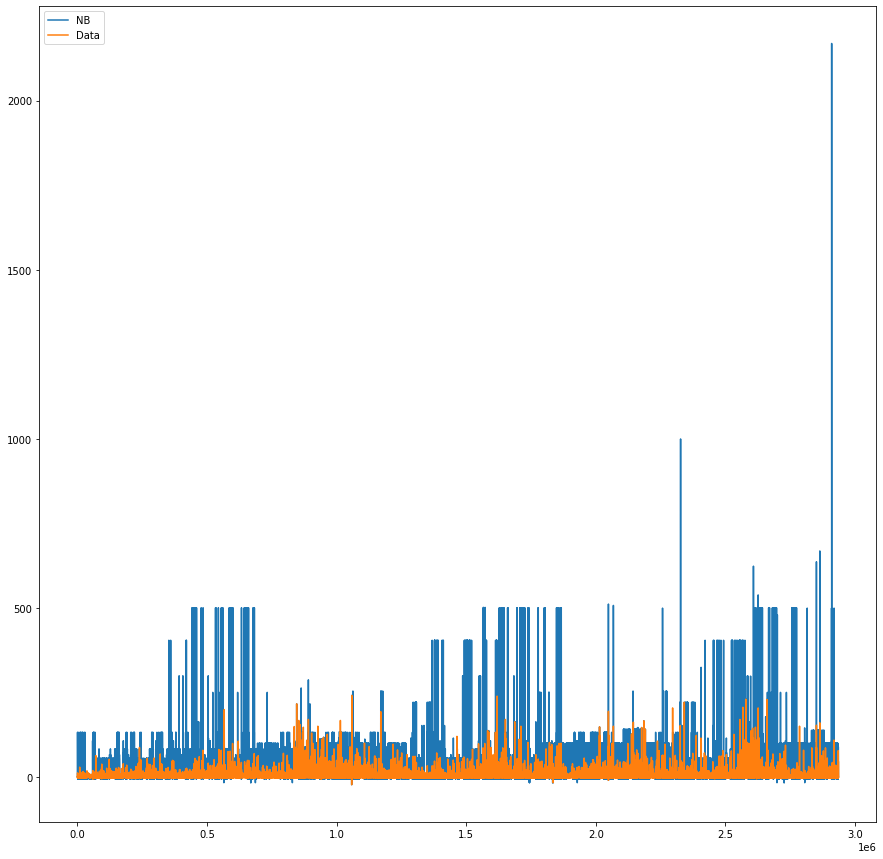

In [65]:
plt.figure(figsize=(15,15))
plt.plot(y_NB, label='NB')
plt.plot(df_without_stuffing['item_cnt_day'].values, label='Data')
plt.legend()
plt.show()

In [125]:
from sklearn.tree import DecisionTreeRegressor

modelTREE = DecisionTreeRegressor()
modelTREE.fit(X_new_train, Y_new_train)

#R^2
r_sq = modelTREE.score(X_new_train, Y_new_train)
print('R^2 =', r_sq)

R^2 = 0.7290379139504761


In [126]:
y_TREE = modelTREE.predict(X_new_test)

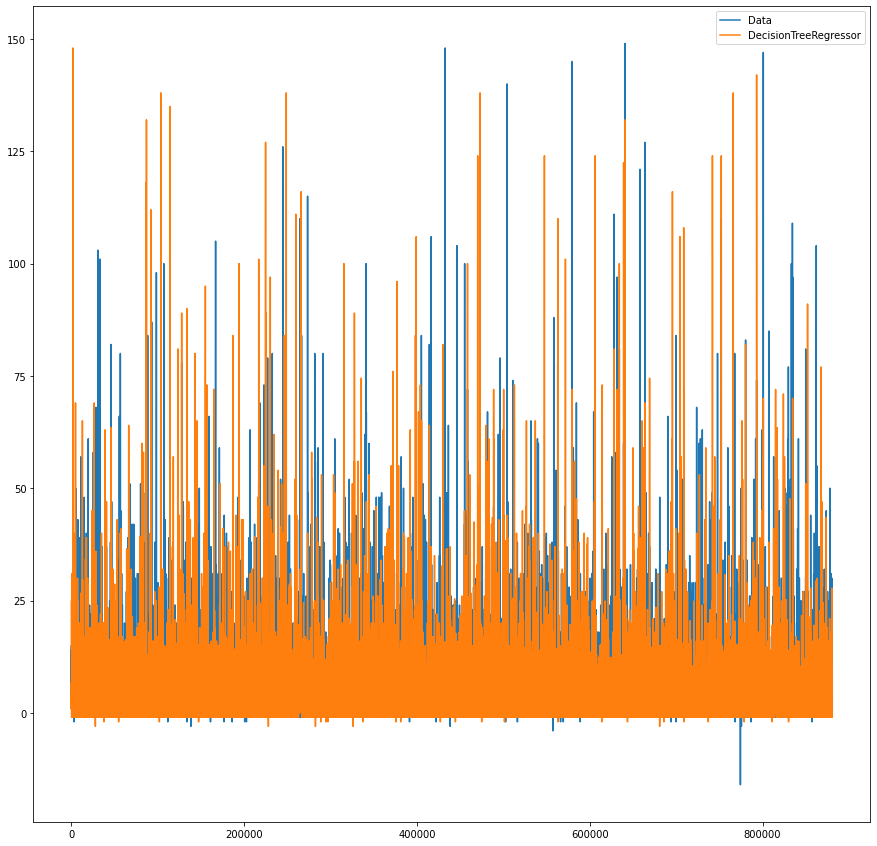

In [127]:
plt.figure(figsize=(15,15))
plt.plot(Y_new_test, label='Data')
plt.plot(y_TREE, label='DecisionTreeRegressor')
plt.legend()
plt.show()

In [129]:
print('средняя абсолютная процентная ошибка =', MAPE(Y_new_test, y_TREE))

средняя абсолютная процентная ошибка = 0.17493856769034732


In [134]:
from sklearn.neighbors import KNeighborsRegressor

modelLasso = KNeighborsRegressor()
modelLasso.fit(X_new_train, Y_new_train)

#R^2
r_sq = modelLasso.score(X_new_train, Y_new_train)
print('R^2 =', r_sq)

y_Lasso = modelLasso.predict(X_new_test)

R^2 = 0.4490824125317


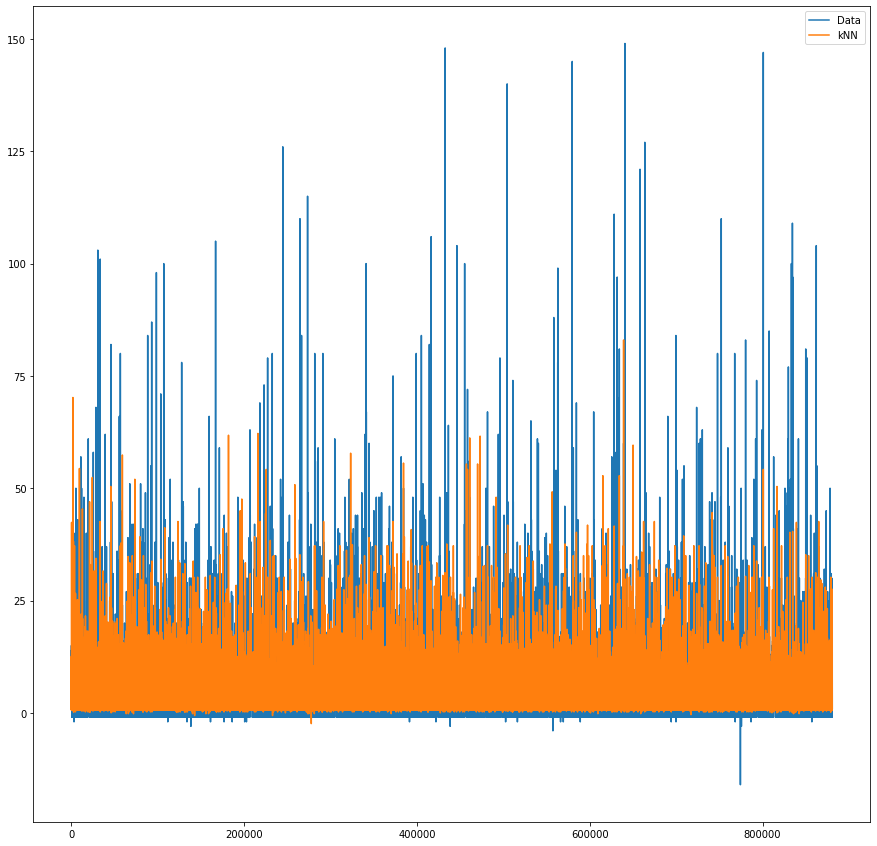

In [136]:
plt.figure(figsize=(15,15))
plt.plot(Y_new_test, label='Data')
plt.plot(y_Lasso, label='kNN')
plt.legend()
plt.show()

In [137]:
print('средняя абсолютная процентная ошибка =', MAPE(Y_new_test, y_Lasso))

средняя абсолютная процентная ошибка = 0.17222107894418012


<h1> Частичные суммы Фурье для месяца и дня недели</h1>

In [151]:
df_for_fure = df_without_stuffing.copy()
df_for_fure.head()

,item_id,item_price,months,day_of_week,category_id,town_id,item_cnt_day
0,22154,999.00,1,2,37,31,1.0
1,2552,899.00,1,3,58,14,1.0
2,2552,899.00,1,5,58,14,-1.0
3,2554,1709.05,1,6,58,14,1.0
4,2555,1099.00,1,1,56,14,1.0


In [152]:
one_m = [1 for i in range(len(df_for_fure))]
sinus_m = [np.sin(2*pi*(i-1)/12) for i in range(0, len(df_for_fure))]
cosinus_m = [np.cos(2*pi*(i-1)/12) for i in range(0, len(df_for_fure))]

In [153]:
data_m = {'one': one_m,
        'months': df_for_fure['months'].values,
        'sin': sinus_m,
        'cos': cosinus_m}
df_m = pd.DataFrame(data_m)
df_m.head()

,one,months,sin,cos
0,1,1,-0.500000,8.660254e-01
1,1,1,0.000000,1.000000e+00
2,1,1,0.500000,8.660254e-01
3,1,1,0.866025,5.000000e-01
4,1,1,1.000000,6.123234e-17


In [154]:
def MNK(teta, betta1, betta2, eps, df, col):
    y = np.dot(df, [eps, teta, betta1, betta2])
    return sum((y - col)**2)/(2*len(col))

In [155]:
res = minimize(lambda x: MNK(x[0], x[1], x[2], x[3], df_m, df_for_fure['item_cnt_day']), (0.5, 0.5, 0.5, 0.5))
teta, betta1, betta2, eps = res.x
teta, betta1, betta2, eps

(0.012868325539219865,
 -0.0013080093822144345,
 0.000903909487010404,
 1.1549996672669456)

In [156]:
def predict(teta, betta1, betta2, eps, df):
    return np.dot(df, [eps, teta, betta1, betta2])

In [157]:
pred = predict(teta, betta1, betta2, eps, df_m)

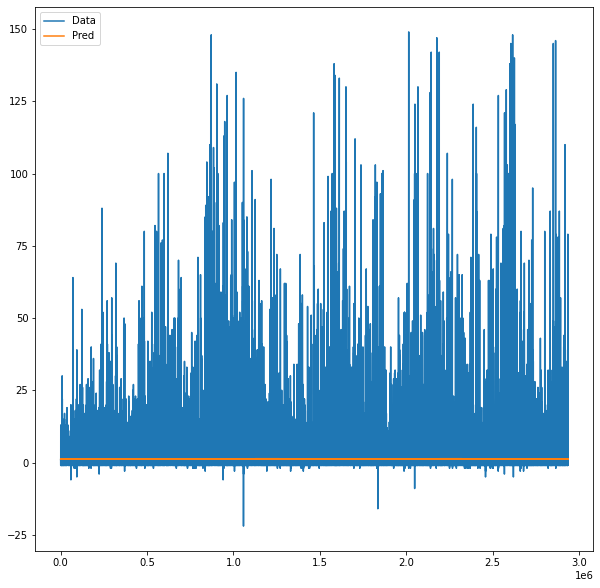

In [160]:
plt.figure(figsize=(10,10))
plt.plot(df_for_fure['item_cnt_day'].values, label='Data')
plt.plot(pred, label='Pred')
plt.legend()
plt.show()

In [162]:
i=0
abs((df_for_fure['item_cnt_day'][i] - pred[i])/Y[i])

0.16930480607574538

In [163]:
print('средняя абсолютная процентная ошибка =', MAPE(df_for_fure['item_cnt_day'], pred))

KeyError: 566159

Проанализируем данные из таблицы Продаж

In [6]:
# размер данных
sales_train.shape

(2935849, 6)

Почти 3 миллиона продаж

In [7]:
# найдем 10 самых продаваемых продукта
count_sales = sales_train.groupby('item_id').size()
top_ten = count_sales.sort_values().tail(10)
top_ten

item_id
3734      5805
4870      5811
2308      6320
3732      6475
7856      6602
4181      6853
2808      7479
17717     9067
5822      9408
20949    31340
dtype: int64

построим для каждого продукта график продаж

In [8]:
item_id_list = top_ten.index

In [9]:
top1 = sales_train[sales_train['item_id'] == item_id_list[0]]
top1 = top1.set_index('date')

top2 = sales_train[sales_train['item_id'] == item_id_list[1]]
top2 = top2.set_index('date')

top3 = sales_train[sales_train['item_id'] == item_id_list[2]]
top3 = top3.set_index('date')

top4 = sales_train[sales_train['item_id'] == item_id_list[3]]
top4 = top4.set_index('date')

top5 = sales_train[sales_train['item_id'] == item_id_list[4]]
top5 = top5.set_index('date')

top6 = sales_train[sales_train['item_id'] == item_id_list[5]]
top6 = top6.set_index('date')

top7 = sales_train[sales_train['item_id'] == item_id_list[6]]
top7 = top7.set_index('date')

top8 = sales_train[sales_train['item_id'] == item_id_list[7]]
top8 = top8.set_index('date')

top9 = sales_train[sales_train['item_id'] == item_id_list[8]]
top9 = top9.set_index('date')

top10 = sales_train[sales_train['item_id'] == item_id_list[9]]
top10 = top10.set_index('date')

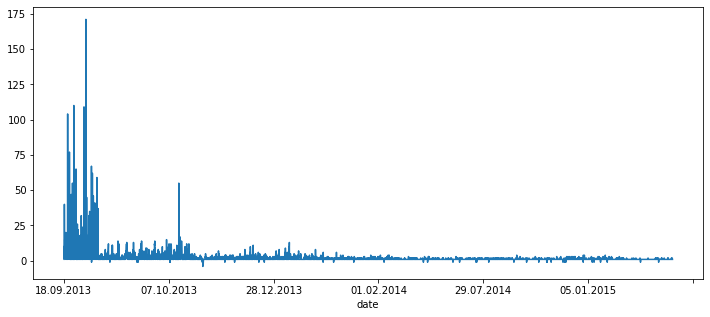

In [10]:
top1['item_cnt_day'].plot(figsize=(12,5))
plt.show()

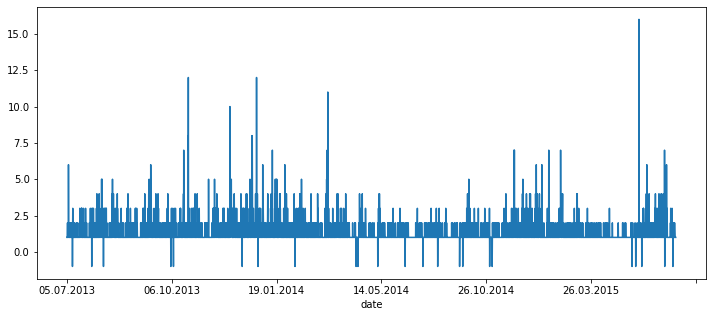

In [11]:
top2['item_cnt_day'].plot(figsize=(12,5))
plt.show()

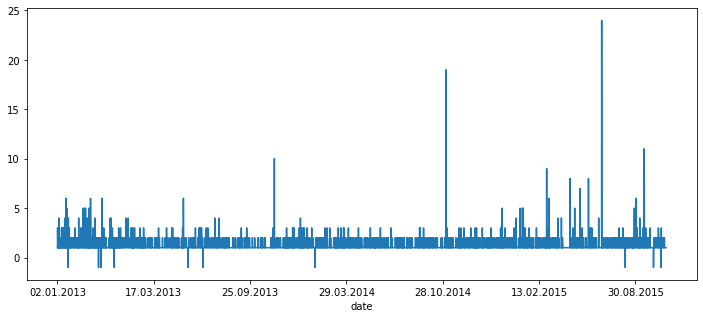

In [12]:
top3['item_cnt_day'].plot(figsize=(12,5))
plt.show()

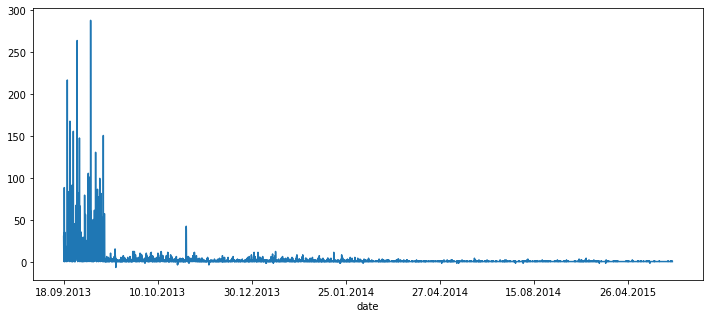

In [13]:
top4['item_cnt_day'].plot(figsize=(12,5))
plt.show()

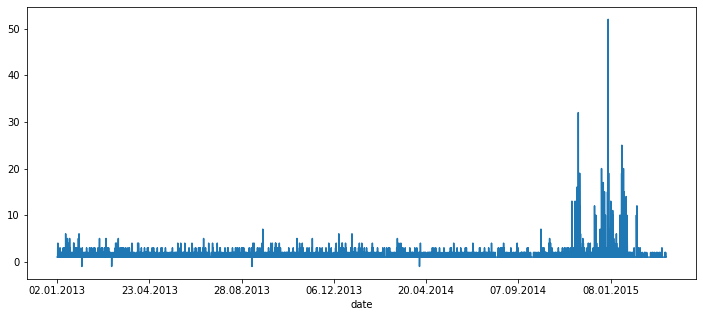

In [14]:
top5['item_cnt_day'].plot(figsize=(12,5))
plt.show()

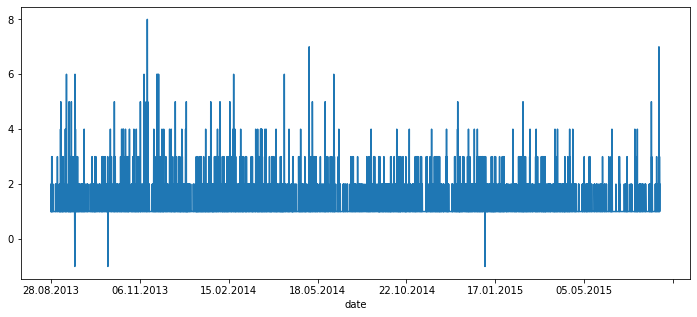

In [15]:
top6['item_cnt_day'].plot(figsize=(12,5))
plt.show()

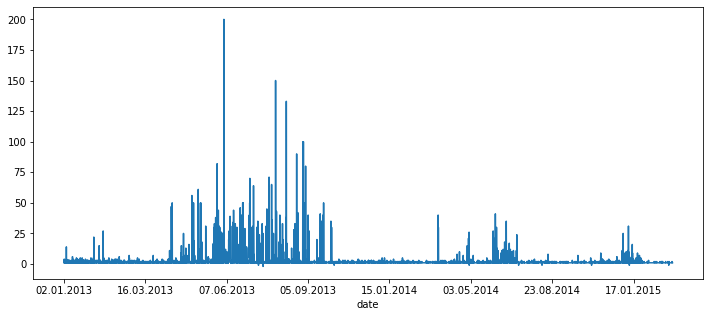

In [16]:
top7['item_cnt_day'].plot(figsize=(12,5))
plt.show()

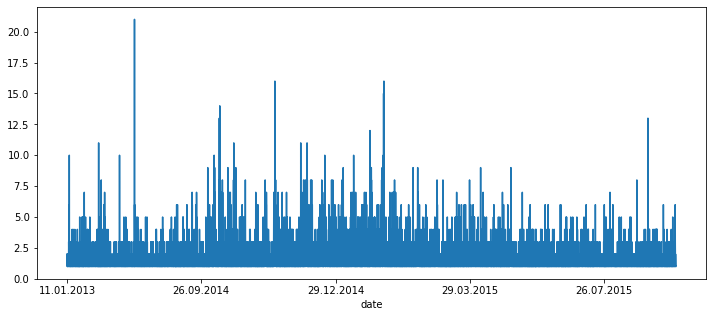

In [17]:
top8['item_cnt_day'].plot(figsize=(12,5))
plt.show()

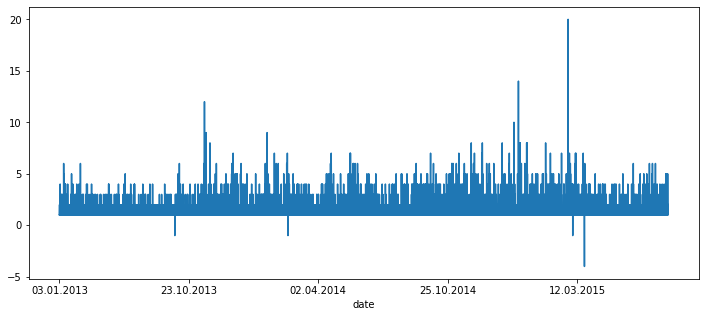

In [18]:
top9['item_cnt_day'].plot(figsize=(12,5))
plt.show()

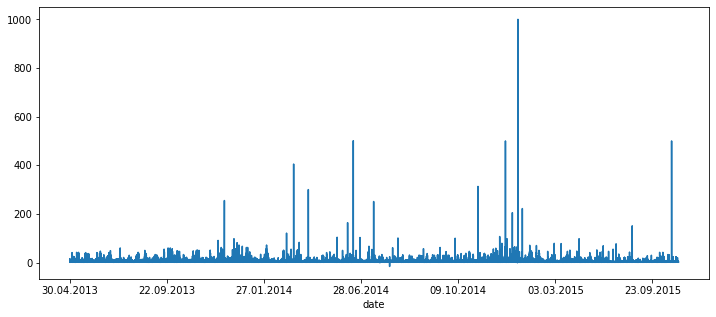

In [19]:
top10['item_cnt_day'].plot(figsize=(12,5))
plt.show()